Wayne H Nixalo - 5 July 2017 : 00:02

FAI01 - Practical Deep Learning I

Lesson 7: Exotic CNN Architectures - JNB CodeAlong

[L7JNB](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson7.ipynb) | [Lecture 7](https://youtu.be/Q0z-l2KRYFY)

# Fisheries competition

In this notebook we're going to investigate a range of difference architectures for the [Kaggle Fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/). The video states that `vgg.py` and `vgg_ft()` from `utils.py` have been updated to include VGG with Batch Normalization, but this isn't the case. We've instead created a new file [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py) and an additional method `vgg_ft_bn()` (which is already in `utils.py`) which we use in this notebook.

In [1]:
import theano
%matplotlib inline
import sys, os
sys.path.insert(1, os.path.join('../utils'))
import utils; reload(utils)
from utils import *
from __future__ import print_function, division

/home/wnixalo/miniconda3/envs/FAI/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 870M (0000:01:00.0)
Using Theano backend.


In [2]:
# path = "data/fisheries/sample/" # MACOSX
path = "data/fisheries/" # UBUNTULINUX
# batch_size = 64
# batch_size = 16
batch_size = 12

In [3]:
%cd ..

/home/wnixalo/Kaukasos/FAI


In [4]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels,
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 13153 images belonging to 1 classes.


Someties it's helpful to have just the filenames, without the path.

In [5]:
raw_filenames      = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames  = [f.split('/')[-1] for f in val_filenames]

----
## I. Setup Dirs:

We create the validation and sample sets in the usual way.

In [ ]:
%cd data/fisheries
%cd train
%mkdir ../valid

In [ ]:
%cd data/fisheries/test_stg2

In [ ]:
g = glob('*.jpg')
for img in g: os.rename(img, '../test/' + img)

In [ ]:
%pwd

In [ ]:
%cd ../..

In [ ]:
g = glob('*.jpg')
for img in g: os.rename(img, 'unknown/' + img)

In [ ]:
# makes a copy of each category folder in /valid
g = glob('*')
for d in g: os.mkdir('../valid/' + d)

# move 500 random folder/img pairs from /train to /valid
# not perfectly proportional (closer w/ more imgs)
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(500): os.rename(shuf[i], '../valid/' + shuf[i])

In [ ]:
%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid

In [ ]:
from shutil import copyfile # copying files requires module import

# make corresponding categ folders in sample dir
g = glob('*')
for d in g:
    os.mkdir('../sample/train/' + d)
    os.mkdir('../sample/valid/' + d)

In [ ]:
# copy 400 random folder/img pairs to sample folder (val:200)

# for training set
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(400): copyfile(shuf[i], '../sample/train/' + shuf[i])

%cd ../valid

# for valid set
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/valid/' + shuf[i])
    
%cd ..

In [ ]:
%mkdir results
%mkdir sample/results
%cd ../..
# %cd data/fisheries

---
## II. Basic VGG

We start with our usual VGG approach. We'll be using VGG w/ Batch Normalization. We explained how to add batch normalization to VGG in the [imagenet_batchnorm_notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/imagenet_batchnorm.ipynb). VGG with batchnorm is implemented in [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py), and there is a version of `vgg_ft` (our finetuning function) with batch norm called `vgg_ft_bn` in [utils.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py).

### Initial Model

First we create a simple fine-tuned VGG model to be our starting point.

In [6]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)

`get_data(.)` calls `get_batches(.)` and uses `np.concatenate(.)` to create one long array of all the data. Yikes RIP Memory. `get_batches(.)` calls `gen.flow_from_directory(.)`. This is good and friendly: I can simply call `get_batches(.)` directory, as it returns a batch generator. This solveds the memory issue. On a Linux machine w/ 16 GB of RAM, loading `trn`, `val`, and `test` directly into memory via `get_data(.)` uses up 99.5% of Memory and 38.5% of Swap. That is very not good. I haven't even done any convolutional stuff yet.

In [ ]:
# trn = get_data(path + 'train')
# val = get_data(path + 'valid')

In [ ]:
# test = get_data(path + 'test')

In [ ]:
# os.mkdir(path + 'results/')

In [ ]:
# save_array(path + 'results/trn.dat', trn)
# save_array(path + 'results/val.dat', val)

In [ ]:
# save_array(path + 'results/test.dat', test)

In [7]:
# trn = load_array(path + 'results/trn.dat')
# val = load_array(path + 'results/val.dat')
# test = load_array(path + 'results/test.dat')

trn_batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)
test_batches = get_batches(path+'test', batch_size=batch_size*2, shuffle=False)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 13153 images belonging to 1 classes.


In [8]:
gen = image.ImageDataGenerator()

In [9]:
model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.save_weights(path + 'results/ft1.h5')

### Precompute Convolutional Output

We pre-compute the output of the last convolutional layer of VGG, since we're unlikely to need to fine-tune those layers. (All following analysis will be done on just the pre-computed convolutional features).

In [ ]:
# model.load_weights(path + 'results/ft1.h5')

In [12]:
# just took a look at `spli_at(..)` in utils.py; this function's awesome
conv_layers, fc_layers = split_at(model, Convolution2D)

In [13]:
conv_model = Sequential(conv_layers)

In [19]:
# sys.path.insert(1, os.path.join('utils'))

# # import utils
# reload (utils)
# from utils import *

In [25]:
# conv_feat = conv_model.predict(trn)
# conv_val_feat = conv_model.predict(val)
# conv_test_feat = conv_model.predict(test)

# NOTE: looking at MACOSX mem usage, I think Apple does some memory-caching black magic 
# to not hit the machine's memory cap. <3

conv_feat = conv_model.predict_generator(trn_batches, trn_batches.nb_sample)
conv_val_feat = conv_model.predict_generator(val_batches, val_batches.nb_sample)
conv_test_feat = conv_model.predict_generator(test_batches, test_batches.nb_sample)

Think I understand now - the issue with using predict_generator, and the two procedures I created earlier to create convolutional features and then run predictions on those features in batches. `predict_generator` returns a single np array of predictions. So if the dataset is large enough you'll eventually run out of system memory. If that happens here I'll deal with it.

In [27]:
save_array(path + 'results/conv_feat.dat', conv_feat)
save_array(path + 'results/conv_val_feat.dat', conv_val_feat)
save_array(path + 'results/conv_test_feat.dat', conv_test_feat)

In [ ]:
# conv_feat = load_array(path + 'results/conv_feat.dat')
# conv_val_feat = load_array(path + 'results/conv_val_feat.dat')
# conv_test_feat = load_array(path + 'results/conv_test_feat.dat', conv_test_feat)

In [30]:
conv_feat.shape, conv_val_feat.shape, conv_test_feat.shape

((3277, 512, 14, 14), (500, 512, 14, 14), (13153, 512, 14, 14))

### Train Model

We can now create our first baseline model - a simple 3-Layer FC Net

In [31]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

In [32]:
p = 0.6

In [33]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3,
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 4s - loss: 2.6650 - acc: 0.2624 - val_loss: 2.1081 - val_acc: 0.3260
Epoch 2/3
3277/3277 [==============================] - 4s - loss: 1.6152 - acc: 0.4348 - val_loss: 2.0422 - val_acc: 0.3280
Epoch 3/3
3277/3277 [==============================] - 4s - loss: 1.4041 - acc: 0.4898 - val_loss: 2.0350 - val_acc: 0.3360


In [35]:
bn_model.optimizer.lr = 1e-4
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7,
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/7
3277/3277 [==============================] - 4s - loss: 1.2463 - acc: 0.5352 - val_loss: 2.2698 - val_acc: 0.3220
Epoch 2/7
3277/3277 [==============================] - 4s - loss: 1.1665 - acc: 0.5624 - val_loss: 2.1939 - val_acc: 0.3520
Epoch 3/7
3277/3277 [==============================] - 4s - loss: 1.0633 - acc: 0.5972 - val_loss: 2.3718 - val_acc: 0.3060
Epoch 4/7
3277/3277 [==============================] - 4s - loss: 0.9766 - acc: 0.6332 - val_loss: 2.4549 - val_acc: 0.3240
Epoch 5/7
3277/3277 [==============================] - 4s - loss: 0.8732 - acc: 0.6655 - val_loss: 2.6921 - val_acc: 0.2980
Epoch 6/7
3277/3277 [==============================] - 4s - loss: 0.8645 - acc: 0.6683 - val_loss: 2.6735 - val_acc: 0.3020
Epoch 7/7
3277/3277 [==============================] - 4s - loss: 0.7980 - acc: 0.7016 - val_loss: 2.6889 - val_acc: 0.3280


Self NOTE: difference between `fit` and `fit_generator` is `fit` is running on one array of the entire input data; `fit_generator` takes input data in batches -- different from the `batch_size=..` parameter which is the number of input data to send to the GPU at a time.

In [38]:
path

'data/fisheries/'

In [39]:
os.mkdir(path + 'models')
bn_model.save_weights(path + 'models/conv_512_6.h5')

In [42]:
bn_model.evaluate(conv_val_feat, val_labels, batch_size=32)

480/500 [===========================>..] - ETA: 0s

[2.688850368499756, 0.32800000000000001]

In [ ]:
bn_model.load_weights(path + 'models/conv_512_6.h5')

---
## III. Multi-Input

The images are of different sizes, which are likely to represent the boat they came from (since different boats will use different cameras). Perhaps this creates some data leakage that we can take advantage of to get a better Kaggle leaderboard position? To find out, first we createa arrays of the file sizes for each image:

In [43]:
# creates array of all image sizes
sizes = [PIL.Image.open(path + 'train/' + f).size for f in filenames]
# creates set of image sizes (all unique sizes)
id2size = list(set(sizes))
# creates dictionary of image size to index <-- for one-hotting
size2id = {o:i for i,o in enumerate(id2size)}

In [44]:
import collections
collections.Counter(sizes)

Counter({(1192, 670): 172,
         (1244, 700): 19,
         (1276, 718): 185,
         (1280, 720): 1895,
         (1280, 750): 514,
         (1280, 924): 53,
         (1280, 974): 340,
         (1334, 750): 30,
         (1518, 854): 36,
         (1732, 974): 33})

Then we One-Hot Encode them (since we want to treat them as categorical) and normalize the data.

In [45]:
# one-hot encode images
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

In [46]:
trn_sizes_orig[0]

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.])

In [47]:
# same proc as `sizes` above; for val imgs
raw_val_sizes = [PIL.Image.open(path + 'valid/' + f).size for f in val_filenames]
id2size = list(set(raw_val_sizes))
size2id = {o:i for i,o in enumerate(id2size)}

# one-hot encoding
val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))

In [48]:
# aha, this get's the normalized sizes of the images:
# subtract mean, divide by standard deviation
trn_sizes = trn_sizes_orig - trn_sizes_orig.mean(axis=0) / trn_sizes_orig.std(axis=0)
val_sizes = val_sizes - trn_sizes_orig.mean(axis=0) / trn_sizes_orig.std(axis=0)

In [49]:
id2size[:]
size2id
# sizes

{(1192, 670): 4,
 (1244, 700): 1,
 (1276, 718): 6,
 (1280, 720): 5,
 (1280, 750): 7,
 (1280, 924): 9,
 (1280, 974): 0,
 (1334, 750): 3,
 (1518, 854): 8,
 (1732, 974): 2}

To use this additional 'meta-data', we create a model with multiple input layers - `sz_inp` will be our input for the size information.

In [50]:
# input: convolutional layers
inp = Input(conv_layers[-1].output_shape[1:])
# size input
sz_inp = Input((len(id2size),))
# batchnormed size input
bn_inp = BatchNormalization()(sz_inp)

# as usual: convolutional features in:
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
# size input merged in here
x = merge([x, bn_inp], 'concat')
x = Dense(8, activation='softmax')(x)

When we compile the mdoel, we have to specify all the input layers in an array

In [51]:
model = Model([inp, sz_inp], x)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

And when we train the model, we have to provide all the input layers' data in an array:

In [52]:
model.fit([conv_feat, trn_sizes], trn_labels, batch_size=batch_size, nb_epoch=3,
             validation_data=([conv_val_feat, val_sizes], val_labels))
# NOTE: this is attempting to take advantage of data leakage

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 4s - loss: 2.4628 - acc: 0.2719 - val_loss: 2.1186 - val_acc: 0.3260
Epoch 2/3
3277/3277 [==============================] - 4s - loss: 1.8359 - acc: 0.3918 - val_loss: 1.7509 - val_acc: 0.4380
Epoch 3/3
3277/3277 [==============================] - 4s - loss: 1.6256 - acc: 0.4513 - val_loss: 1.7045 - val_acc: 0.4420


In [53]:
# I think this is comparing multi input model to single input model:
bn_model.optimizer.lr = 1e-4
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=8,
          validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/8
3277/3277 [==============================] - 4s - loss: 0.7651 - acc: 0.7150 - val_loss: 2.8747 - val_acc: 0.3120
Epoch 2/8
3277/3277 [==============================] - 4s - loss: 0.7348 - acc: 0.7309 - val_loss: 2.8648 - val_acc: 0.2960
Epoch 3/8
3277/3277 [==============================] - 4s - loss: 0.6950 - acc: 0.7495 - val_loss: 2.8447 - val_acc: 0.3000
Epoch 4/8
3277/3277 [==============================] - 4s - loss: 0.6675 - acc: 0.7473 - val_loss: 2.8231 - val_acc: 0.3220
Epoch 5/8
3277/3277 [==============================] - 4s - loss: 0.6289 - acc: 0.7626 - val_loss: 2.9783 - val_acc: 0.2900
Epoch 6/8
3277/3277 [==============================] - 4s - loss: 0.5896 - acc: 0.7806 - val_loss: 3.0778 - val_acc: 0.2940
Epoch 7/8
3277/3277 [==============================] - 4s - loss: 0.5973 - acc: 0.7775 - val_loss: 3.0201 - val_acc: 0.3100
Epoch 8/8
3277/3277 [==============================] - 4s - loss: 0.5789 - acc: 0.786

*NOTE: this Multi-IO model only outperforms standard BN model in the first few epochs (see first runs of BN Model)*

The model didn't show an improvement by using the leakage, other than in the early epochs. THis is most likely because the information about what boat the picture came from is readily identified from the image itself, so the meta-data turned out not to add any additional information.

---
## IV. Bounding Boxes & Multi Output

### Import / View Bounding Boxes

A kaggle user has created bounding box annotations for each fish in each training set image. You can download them [from here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/forums/t/25902/complete-bounding-box-annotation). We'll see if we can utilize this additional information. First, we'll load in the data, and keep just the largest bounding box for each image.

In [55]:
# UltraJSON -- "ultra-fast JSON decoder for Python, written in pure C"
import ujson as json

In [56]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [58]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('{}annos/{}_labels.json'.format(path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations']) > 0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height'] * x['width'])[-1]
# format of j:
# [
#     {
#         "annotations": [
#             {
#                 "class": "rect",
#                 "height": 89.0,
#                 "width": 355.0,
#                 "x": 512.0,
#                 "y": 162.0
#             },
#             .......
#             .......
#         ],
#         "class": "image",
#         "filename": "img_07825.jpg"
#     },
#     .....
#     .....
# ]

# the files need to be downloaded and placed in `path`/annos/ first

In [59]:
bb_json['img_04908.jpg']

{u'class': u'rect',
 u'height': 246.75000000000074,
 u'width': 432.8700000000013,
 u'x': 465.3000000000014,
 u'y': 496.32000000000147}

In [60]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

For any images that have no annotations, we'll create an empt bounding box:

In [61]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [62]:
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

Finally, we convert the dictionary into an array, and convert the coordiantes to our resized 224x224 images.

In [63]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0] * conv_y
    bb[1] = bb[1] * conv_x
    bb[2] = max(bb[2] * conv_x, 0)
    bb[3] = max(bb[3] * conv_y, 0)
    return bb
# fn creates a list of the largest fish in ea. image & places box arn them

In [64]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)],
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s)
                    for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

Now we can check our work by drawing one of the annotations:

In [131]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)
def show_bb(i):
    bb = val_bbox[i]
#     plot(val[i])
    plot(ith_val(i)[-1])
    plot(val(i)[0])
    plt.gca().add_patch(create_rect(bb))

Found 500 images belonging to 8 classes.


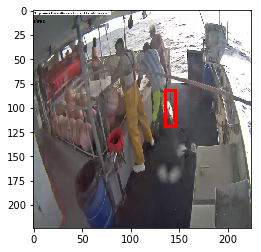

In [118]:
# little script to pull ith img from val dataset without loading all val into memory
def ith_val(i):
    batches = get_batches(path + 'valid', shuffle=False, batch_size=1, class_mode=None, target_size=(224,224))
#     return np.concatenate([batches.next() for j in range(i+1)])
    for j in range(i+1): val = batches.next()
    return np.concatenate([val])

# # this does the job of the `ith_val(i)` function
# val = lambda i: np.concatenate([get_batches(path+'valid',shuffle=False,batch_size=1,class_mode=None,target_size=(224,224)).next() for j in range(i+1)])


show_bb(0)

### Create & Train Model:

Sicne we're not allowed (by the Kaggle rules) to manually annotate the test set, we'll need to create a model that predicts the locations of the bounding box on each image. To do so, we create a model with multiple outputs: it'll predict both the type of fish (the 'class'), and the 4 bounding box coordinates. We prefer this approach to only predicting the bounding box coordinates, since we hope that giving the model more context about what it's looking for will help it with both tasks.

In [119]:
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x) # 4 linear outps w/ no actvtn fn -- bb dims
x_class = Dense(8, activation='softmax', name='class')(x)
# this model'll have to figure out how to come up w/ a bunch of dense layers 
# capable of doing the last 2 lines simultaneously.

Since we have multiple outputs, we need to provide them to the model constructor in an array, and we also need to say what loss function to use for each. We also weight the bounding box loss function down by 1000x, since the scales of the Cross-Entropy Loss and the MSE are very different.

In [120]:
model = Model([inp], [x_bb, x_class]) # optmz: x_bb:mse; x_class:catgXentrop
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[0.001, 1.0]) # scale 1st loss (mse) by 0.001

In [121]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=3,
             validation_data=(conv_val_feat, [val_bbox, val_labels]))
# [trn_bbox, trn_labels], <<- use bbs as labels for 1st outp, fish types for 2nd outp

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 4s - loss: 7.5086 - bb_loss: 5041.8368 - class_loss: 2.4668 - bb_acc: 0.2637 - class_acc: 0.2579 - val_loss: 6.8872 - val_bb_loss: 4717.8053 - val_class_loss: 2.1694 - val_bb_acc: 0.3060 - val_class_acc: 0.3720
Epoch 2/3
3277/3277 [==============================] - 4s - loss: 6.2105 - bb_loss: 4304.1680 - class_loss: 1.9063 - bb_acc: 0.3488 - class_acc: 0.3860 - val_loss: 5.3826 - val_bb_loss: 3474.1595 - val_class_loss: 1.9084 - val_bb_acc: 0.3800 - val_class_acc: 0.3900
Epoch 3/3
3277/3277 [==============================] - 4s - loss: 4.3942 - bb_loss: 2655.6823 - class_loss: 1.7386 - bb_acc: 0.4156 - class_acc: 0.4214 - val_loss: 3.6691 - val_bb_loss: 1835.6106 - val_class_loss: 1.8335 - val_bb_acc: 0.4260 - val_class_acc: 0.4240


In [122]:
model.optimizer.lr = 1e-5
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10,
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
3277/3277 [==============================] - 4s - loss: 3.2580 - bb_loss: 1594.7662 - class_loss: 1.6633 - bb_acc: 0.4434 - class_acc: 0.4233 - val_loss: 3.4158 - val_bb_loss: 1453.5235 - val_class_loss: 1.9622 - val_bb_acc: 0.4380 - val_class_acc: 0.3580
Epoch 2/10
3277/3277 [==============================] - 4s - loss: 2.9960 - bb_loss: 1413.3766 - class_loss: 1.5826 - bb_acc: 0.4507 - class_acc: 0.4318 - val_loss: 3.2918 - val_bb_loss: 1450.7869 - val_class_loss: 1.8411 - val_bb_acc: 0.4240 - val_class_acc: 0.3700
Epoch 3/10
3277/3277 [==============================] - 4s - loss: 2.8973 - bb_loss: 1374.1114 - class_loss: 1.5232 - bb_acc: 0.4513 - class_acc: 0.4654 - val_loss: 3.4470 - val_bb_loss: 1510.1353 - val_class_loss: 1.9368 - val_bb_acc: 0.4440 - val_class_acc: 0.3920
Epoch 4/10
3277/3277 [==============================] - 4s - loss: 2.8195 - bb_loss: 1357.5417 - class_loss: 1.4619 - bb_acc: 0.4461 - class_acc: 0.4760

*NOTE: bb loss is ~1000x larger than class loss. Hense the scaling. Note also its more stable*

Excitingly, it turned out that the classification model is much improved by giving it this additional task. Let's see how well the bounding box model did by taking a look at its output:

In [143]:
model.optimizer.lr = 1e-5
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10,
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
3277/3277 [==============================] - 4s - loss: 2.3025 - bb_loss: 1196.1320 - class_loss: 1.1063 - bb_acc: 0.4678 - class_acc: 0.5957 - val_loss: 3.8571 - val_bb_loss: 1607.3780 - val_class_loss: 2.2497 - val_bb_acc: 0.4220 - val_class_acc: 0.3360
Epoch 2/10
3277/3277 [==============================] - 4s - loss: 2.2389 - bb_loss: 1168.8433 - class_loss: 1.0700 - bb_acc: 0.4821 - class_acc: 0.6009 - val_loss: 3.8573 - val_bb_loss: 1579.5888 - val_class_loss: 2.2778 - val_bb_acc: 0.4280 - val_class_acc: 0.3500
Epoch 3/10
3277/3277 [==============================] - 4s - loss: 2.2105 - bb_loss: 1148.9250 - class_loss: 1.0616 - bb_acc: 0.4876 - class_acc: 0.5996 - val_loss: 4.0153 - val_bb_loss: 1632.9434 - val_class_loss: 2.3823 - val_bb_acc: 0.4160 - val_class_acc: 0.2960
Epoch 4/10
3277/3277 [==============================] - 4s - loss: 2.1408 - bb_loss: 1126.3235 - class_loss: 1.0145 - bb_acc: 0.4879 - class_acc: 0.6170

In [144]:
# do prediction for 1st 10 validation images
pred = model.predict(conv_val_feat[0:10])

In [145]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
#     plot(val[i])
    plot(ith_val(i)[-1])
#     plot(val(i)[0])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

The image shows that it can find fish that are tricky even for us to see!

*although w/ the much smaller sample dataset on the MAC, performance is pretty abysmal on the examples.. but should be v.good on the Linux machine*

Found 500 images belonging to 8 classes.


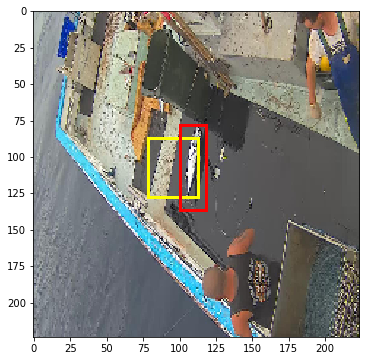

In [149]:
show_bb_pred(8)
# for i in range(40, 50):
#     show_bb_pred(i)

The above is after 23 epochs. After 35:

In [150]:
model.optimizer.lr = 1e-5
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=12,
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/12
3277/3277 [==============================] - 4s - loss: 1.8956 - bb_loss: 1045.1917 - class_loss: 0.8504 - bb_acc: 0.5215 - class_acc: 0.6857 - val_loss: 4.3907 - val_bb_loss: 1693.1031 - val_class_loss: 2.6976 - val_bb_acc: 0.4040 - val_class_acc: 0.3320
Epoch 2/12
3277/3277 [==============================] - 4s - loss: 1.8271 - bb_loss: 1014.7039 - class_loss: 0.8124 - bb_acc: 0.5163 - class_acc: 0.6897 - val_loss: 4.5135 - val_bb_loss: 1696.6731 - val_class_loss: 2.8168 - val_bb_acc: 0.3920 - val_class_acc: 0.3060
Epoch 3/12
3277/3277 [==============================] - 4s - loss: 1.7942 - bb_loss: 1012.2677 - class_loss: 0.7819 - bb_acc: 0.5267 - class_acc: 0.7092 - val_loss: 4.6350 - val_bb_loss: 1722.7233 - val_class_loss: 2.9123 - val_bb_acc: 0.3900 - val_class_acc: 0.3480
Epoch 4/12
3277/3277 [==============================] - 4s - loss: 1.7442 - bb_loss: 977.9318 - class_loss: 0.7663 - bb_acc: 0.5313 - class_acc: 0.7135 

Found 500 images belonging to 8 classes.


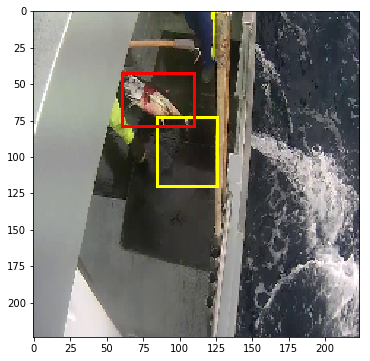

In [159]:
# preds = model.predict((conv_val_feat[:10]))
show_bb_pred(6)

*NOTE: a powerful model will crop out these fish and run them through a second model*

In [160]:
model.evaluate(conv_val_feat, [val_bbox, val_labels])

416/500 [=======================>......] - ETA: 0s

[4.7388352966308593,
 1731.8249091796874,
 3.0070102653503419,
 0.39399999952316284,
 0.33800000005960462]

In [161]:
model.save_weights(path + 'models/bn_anno.h5')
# model.load_weights(path + 'models/bn_anno.h5')

---
## V. Larger Size

### Set up Data

Let's see if we get better results if we use larger images. We'll use 640x360, since it's the same shape as the most common size we saw earlier (1280x720), without being too big.

In [6]:
# trn = get_data(path + 'train', (360, 640))
# val = get_data(path + 'valid', (360, 640))
# remember image dimensions are width x height, but 
# matrix dims are rows X columns; (reversed)

# NOTE: the above is ver memory intensive: will use batches here instead:
trn_batches = get_batches(path+'train',shuffle=False,batch_size=batch_size,class_mode='categorical',
                          target_size=(360,640))
val_batches = get_batches(path+'valid',shuffle=False,batch_size=batch_size,class_mode='categorical',
                          target_size=(360,640))

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


In [7]:
# generalizing the ith_val function from above
def ith_datum(i, data_type='train', target_size=(360,640)):
    batches = get_batches(path + data_type, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    for j in range(i+1): datum = batches.next()
#     return np.concatenate([datum])
    return datum[0]

The image shows that things are much clearer at this size.

Found 3277 images belonging to 8 classes.


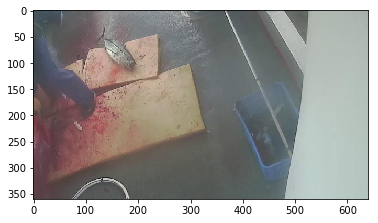

In [8]:
# plot(trn[0])
plot(ith_datum(0, 'train', (360,640)))

In [9]:
# test = get_data(path + 'test', (360, 640))
test_batches = get_batches(path+'test', shuffle=False, batch_size=batch_size,
                           target_size=(360,640))

Found 13153 images belonging to 1 classes.


NOTE: `class_mode=None` only for the replacements for `get_data(.)` ie: when you're just trying to look at the data. Use `class_mode='categorical'` as standard for `get_batches(.)` when normally defining batches. This may have accounted for some subpar training performance earlier.

In [ ]:
# save_array(path + 'results/trn_640.dat', trn)
# save_array(path + 'results/val_640.dat', val)
# save_array(path + 'results/test_640.dat', test)

In [ ]:
# trn = load_array(path + 'results/trn_640.dat')
# val = load_array(path + 'results/val_640.dat')

We can now create our VGG model - we'll need to tell it we're not using the normal 224x224 images, which also means it won't include the Fully-Connected layers (since they don't make sense for non-default sizes). We'll also remove the last Max-Pooling layer, since we don't want to throw away information yet.

In [11]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop() # we don't want the last MaxPooling layer 
# vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])
vgg640.input_shape, vgg640.output_shape

((None, 3, 360, 640), (None, 512, 22, 40))

NOTE: ran out of GPU memory at this point: batch_size=16; Mem usage: 2731/3017 MiB - restarting kernel

Maybe it's because 640x360 images require more memory thatn 224x224... lol yeah of course it is.

In [12]:
# NOTE: `model.predict(.)` takes in the entire input array.
#       'model.predict_generator(.)` takes in input data in batches.
#       both do computation in batches and return the full array of predictions.

# conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
# conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)

# del conv_feat # freeing some memory

conv_val_feat = vgg640.predict_generator(val_batches, val_batches.nb_sample)
conv_trn_feat = vgg640.predict_generator(trn_batches, trn_batches.nb_sample)

In [13]:
save_array(path + 'results/conv_val_640.dat', conv_val_feat)
save_array(path + 'results/conv_trn_640.dat', conv_trn_feat)

In [14]:
del conv_val_feat
del conv_trn_feat

In [16]:
# conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

conv_test_feat = vgg640.predict_generator(test_batches, test_batches.nb_sample)

In [17]:
save_array(path + 'results/conv_test_640.dat', conv_test_feat)

In [19]:
del conv_test_feat

In [ ]:
# conv_val_feat = load_array(path + 'results/conv_val_640.dat')
# conv_trn_feat = load_array(path + 'results/conv_trn_640.dat')
# conv_test_feat = load_array(path + 'results/conv_test_640.dat')

---
## VI. Fully Convolutional Net (FCN)

Since we're using a larger input, the output of the final convolutional layer is also larger. So we probably don't want to put a dense layer there - that would be a *lot* of parameters! Instead, let's use a fully convolutional net (FCN); this also has the benefit that they tend to generalize well, and also seems like a good fit for our problem (since the fish are a small part of the image)

In [20]:
conv_layers, _ = split_at(vgg640, Convolution2D)

J.H.: I'm not using any doprout, since I found I got better results without it.

In [21]:
nf = 128; p = 0

In [22]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1, 2)), # (1,2) MxP to trsfm into square result
        Convolution2D(8, 3, 3, border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [23]:
lrg_model = Sequential(get_lrg_layers())
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 512, 22, 40)   2048        batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 128, 22, 40)   512         convolution2d_27[0][0]           
____________________________________________________________________________________________________
maxpooling2d_11 (MaxPooling2D)   (None, 128, 11, 20)   0           batchnormalization_2[0][0]       
___________________________________________________________________________________________

In [24]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
conv_trn_feat = load_array(path + 'results/conv_trn_640.dat')
conv_val_feat = load_array(path + 'results/conv_val_640.dat')

In [29]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2,
              validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 22s - loss: 0.6954 - acc: 0.7742 - val_loss: 0.4262 - val_acc: 0.8760
Epoch 2/2
3277/3277 [==============================] - 22s - loss: 0.2049 - acc: 0.9319 - val_loss: 0.3103 - val_acc: 0.9240


In [30]:
lrg_model.optimizer.lr=1e-5
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6,
              validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 22s - loss: 0.1247 - acc: 0.9609 - val_loss: 0.2449 - val_acc: 0.9360
Epoch 2/6
3277/3277 [==============================] - 22s - loss: 0.0381 - acc: 0.9890 - val_loss: 0.3267 - val_acc: 0.9280
Epoch 3/6
3277/3277 [==============================] - 22s - loss: 0.0477 - acc: 0.9860 - val_loss: 0.3404 - val_acc: 0.9240
Epoch 4/6
3277/3277 [==============================] - 22s - loss: 0.0618 - acc: 0.9826 - val_loss: 0.3004 - val_acc: 0.9280
Epoch 5/6
3277/3277 [==============================] - 22s - loss: 0.0710 - acc: 0.9789 - val_loss: 0.2332 - val_acc: 0.9380
Epoch 6/6
3277/3277 [==============================] - 22s - loss: 0.0213 - acc: 0.9939 - val_loss: 0.2107 - val_acc: 0.9560


JH: When I submitted the results of this model to Kaggle, I got the best single model results of any shown here (ranked 22nd on the leaderboard as at Dec-6-2016).

In [31]:
lrg_model.save_weights(path + 'models/lrg_nmp.h5')
# lrg_model.load_weights(path + 'models/lrg_nmp.h5')

In [32]:
lrg_model.evaluate(conv_val_feat, val_labels)

480/500 [===========================>..] - ETA: 0s

[0.21072061654180288, 0.95599999999999996]

Another benefit of this kind of model is that the last convolutional layer has to learn to classify each part of the image (since there's only an Average Pooling layer after). Let's create a function that grabs the output of this layer (which is the 4th-last layer of our model).

In [33]:
L = lrg_model.layers
conv_fn = K.function([L[0].input, K.learning_phase()], L[-4].output)

In [34]:
def get_cm(inp, label):
    conv = conv_fn([inp, 0])[0, label]
    return scipy.misc.imresize(conv, (360, 640), interp='nearest')

We have to add an extra dimension to our input since the CNN expects a 'batch' (even if it's just a batch of one).

In [35]:
inp = np.expand_dims(conv_val_feat[0],0)
np.round(lrg_model.predict(inp)[0], 2)

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

Found 500 images belonging to 8 classes.


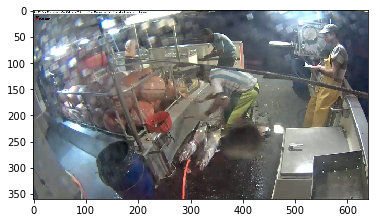

In [41]:
# plt.imshow(to_plot(val[0]))
plt.imshow(to_plot(ith_datum(2, 'valid')))

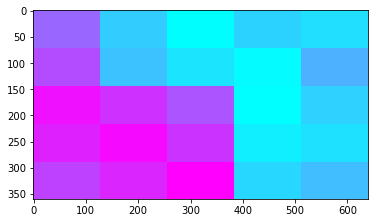

In [42]:
cm = get_cm(inp, 2)
plt.imshow(cm, cmap="cool")

### All Convolutional Net Heatmap

To create a higher resolution heatmap, we'll remove all the max pooling layers, and repeat the previous steps.

In [43]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(8, 3, 3, border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [44]:
lrg_model = Sequential(get_lrg_layers())
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_5 (BatchNorma (None, 512, 22, 40)   2048        batchnormalization_input_2[0][0] 
____________________________________________________________________________________________________
convolution2d_31 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_5[0][0]       
____________________________________________________________________________________________________
batchnormalization_6 (BatchNorma (None, 128, 22, 40)   512         convolution2d_31[0][0]           
____________________________________________________________________________________________________
convolution2d_32 (Convolution2D) (None, 128, 22, 40)   147584      batchnormalization_6[0][0]       
___________________________________________________________________________________________

In [45]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2,
              validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 30s - loss: 0.9381 - acc: 0.7055 - val_loss: 0.7318 - val_acc: 0.8140
Epoch 2/2
3277/3277 [==============================] - 30s - loss: 0.3069 - acc: 0.9075 - val_loss: 0.3278 - val_acc: 0.9060


In [47]:
lrg_model.optimizer.lr=1e-5
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6,
              validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 30s - loss: 0.1634 - acc: 0.9490 - val_loss: 0.2758 - val_acc: 0.9260
Epoch 2/6
3277/3277 [==============================] - 30s - loss: 0.1100 - acc: 0.9673 - val_loss: 0.2351 - val_acc: 0.9440
Epoch 3/6
3277/3277 [==============================] - 30s - loss: 0.0738 - acc: 0.9738 - val_loss: 0.3143 - val_acc: 0.9300
Epoch 4/6
3277/3277 [==============================] - 30s - loss: 0.0597 - acc: 0.9799 - val_loss: 0.2637 - val_acc: 0.9340
Epoch 5/6
3277/3277 [==============================] - 31s - loss: 0.0512 - acc: 0.9844 - val_loss: 0.2724 - val_acc: 0.9240
Epoch 6/6
3277/3277 [==============================] - 31s - loss: 0.0495 - acc: 0.9860 - val_loss: 0.2539 - val_acc: 0.9420


In [48]:
lrg_model.save_weights(path + 'models/lrg_0mp.h5')
# lrg_model.load_weights(path + 'models/lrg_0mp.h5')

#### Create Heatmap

In [49]:
L = lrg_model.layers
conv_fn = K.function([L[0].input, K.learning_phase()], L[-3].output)

In [50]:
# Resize heatmap to 360 by 640
def get_cm2(imp, label):
    conv = conv_fn([inp, 0])[0, label]
    return scipy.misc.imresize(conv, (360, 640))
# by default, .imresize will try to interpolate; replace big pixels w/ 
# interpolated small pixels

In [51]:
inp = np.expand_dims(conv_val_feat[0], 0)

Found 500 images belonging to 8 classes.


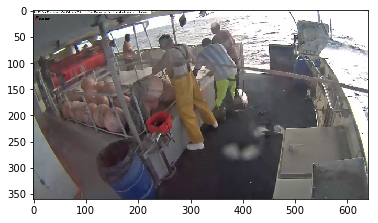

In [52]:
# plt.imshow(to_plot(val[0]))
plt.imshow(to_plot(ith_datum(0, 'valid')))

In [53]:
cm = get_cm2(inp, 0)
# cm = get_cm2(inp, 4)

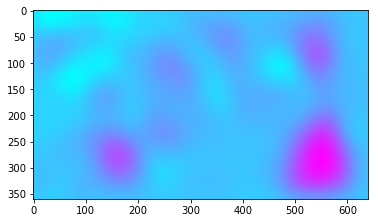

In [54]:
plt.imshow(cm, cmap="cool")

Found 500 images belonging to 8 classes.


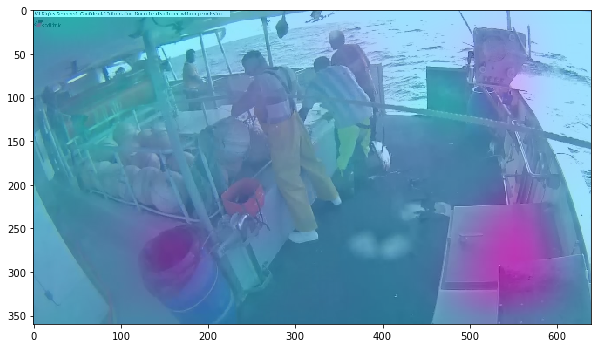

In [55]:
plt.figure(figsize=(10,10))
# plot(val[0])
plot(ith_datum(0, 'valid'))
plt.imshow(cm, cmap="cool", alpha=0.5)

Found 500 images belonging to 8 classes.


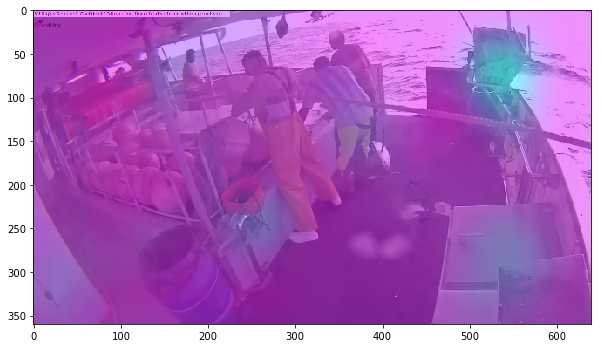

In [56]:
# looking for "No Fish" class:
cm = get_cm2(inp, 4)
plt.figure(figsize=(10,10))
# plot(val[0])
plot(ith_datum(0, 'valid'))
plt.imshow(cm, cmap="cool", alpha=0.5)

*Still looks like this model is looking for features of the boat instead of the fish.*

---
## VI. Inception Mini-Net

Here's an example of how to create and use "Inception Blocks" - as you see, they use multiple different convolution filter sizes and concatenate the reusults together. We'll talk more about these next year.

*NOTE: unable to get this working so far. Searched for a similar problem: *

    ValueError: padding must be zero for average_exc_pad 

*and the [author of Keras said](https://github.com/fchollet/keras/issues/4599#issuecomment-296862194) the solution was to use the TensorFlow backend bc it's a Theano issue. The 2nd part of this course apparently uses InceptionV3 within Keras, so I may hold off for a better supported way like that.*

In [ ]:
def conv2d_bn(x, nb_filter, nb_row, nb_col, subsample=(1,1)):
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample, activation='relu', border_mode='same')(x)
    return BatchNormalization(axis=1)(x)

def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, subsample=(2, 2))
    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample=(2, 2))
    
    branch3x3dbl = conv2d_bn(x, 32, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample=(2, 2))
    
    branch_pool = AveragePooling2D(
        (3, 3), strides=(2, 2), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                mode='concat', concat_axis=1)

In [ ]:
inp = Input(vgg640.layers[-1].output_shape[1:])
x = BatchNormalization(axis=1)(inp)
x = incep_block(x)
x = incep_block(x)
x = incep_block(x)
x = Dropout(0.75)(x)
x = Convolution2D(8,3,3, border_mode='same')(x)
x = GlobalAveragePooling2D()(x)
outp = Activation('softmax')(x)

In [ ]:
lrg_model = Model([inp], outp)
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2,
              validation_data=(conv_val_feat, val_labels))

*Copy-Paste from Lesson 7 JNB gives same result*

In [ ]:
# def conv2d_bn(x, nb_filter, nb_row, nb_col, subsample=(1, 1)):
#     x = Convolution2D(nb_filter, nb_row, nb_col,
#                       subsample=subsample, activation='relu', border_mode='same')(x)
#     return BatchNormalization(axis=1)(x)

# def incep_block(x):
#     branch1x1 = conv2d_bn(x, 32, 1, 1, subsample=(2, 2))
#     branch5x5 = conv2d_bn(x, 24, 1, 1)
#     branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample=(2, 2))

#     branch3x3dbl = conv2d_bn(x, 32, 1, 1)
#     branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
#     branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample=(2, 2))

#     branch_pool = AveragePooling2D(
#         (3, 3), strides=(2, 2), border_mode='same')(x)
#     branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
#     return merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
#               mode='concat', concat_axis=1)

# inp = Input(vgg640.layers[-1].output_shape[1:]) 
# x = BatchNormalization(axis=1)(inp)
# x = incep_block(x)
# x = incep_block(x)
# x = incep_block(x)
# x = Dropout(0.75)(x)
# x = Convolution2D(8,3,3, border_mode='same')(x)
# x = GlobalAveragePooling2D()(x)
# outp = Activation('softmax')(x)

# lrg_model = Model([inp], outp)

# lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
#              validation_data=(conv_val_feat, val_labels))

In [ ]:
lrg_model.optimizer.lr=1e-5
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6,
              validation_data=(conv_val_feat, val_labels))

In [ ]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=10,
             validation_data=(conv_val_feat, val_labels))

In [ ]:
lrg_model.save_weights(path + 'm')

---
Calling it a day here.


## VII. Pseudo-Labeling

In [ ]:

# model.load_weights(path + 'models/bn_anno.h5')

In [60]:
# preds = model.predict([conv_test_feat, test_sizes], batch_size=batch_size*2)
preds = model.predict_generator([])

NameError: name 'model' is not defined

In [ ]:
gen = image.ImageDataGenerator()

In [ ]:
test_batches = gen.flow(conv_test_feat, preds, batch_size=16)

In [ ]:
val_batches = gen.flow(conv_val_feat, val_labels, batch_Size=4)

In [ ]:
batches = gen.flow(conv_feat, trn_labels, batch_size=44)

In [ ]:
mi = MixIterator([batches, test_batches, val_batches]) # I think that's how it's done?

In [ ]:
bn_model.fit_generator(mi, mi.N, nb_epoch=8, validation_data=(conv_val_feat, val_labels))

---
## VIII. Submit

In [57]:
def do_clip(arr, mx): return np.clip(arr, (1 - mx) / 7, mx)

In [58]:
lrg_model.evaluate(conv_val_feat, val_labels, batch_size*2)

500/500 [==============================] - 1s     


[0.25391172198299317, 0.94199999809265134]

In [66]:
# del conv_trn_feat
# del conv_val_feat
del conv_test_feat

# conv_test_feat = load_array(path + 'results/conv_test_640.dat')

# # preds = model.predict(conv_test_feat, batch_size=batch_size)
# preds = lrg_model.predict(conv_test_feat,  batch_size=batch_size)

In [ ]:
preds = preds[1]

In [ ]:
test = load_array(path + 'results/test_640.dat')
# test = load_array(path + 'results/test.dat')

In [ ]:
preds = conv_model.predict(test, batch_size=32)

In [ ]:
subm = do_clip(preds, 0.82)

In [ ]:
subm_name = path + 'results/subm_bb.gz'

In [ ]:
# classes = sorted(batches.class_indices, key=batches.class_indices.get)
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [ ]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

In [ ]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [ ]:
FileLink(subm_name)